# Grade: /100 pts
# Assignment 8: Customer Segmentation with Clustering

In this assignment, you will be solving a traditional problem in quantitative marketing: customer segmentation. Having a properly segmented database is extremely important to define marketing campaigns, as it allows companies to define value-centric actions targeted towards customers of different profiles. In this ocassion you are going to analyze customers of an automobile company.

Assume you are the owner of a consulting company that is in charge of this project. In this assignment you are going to conduct 2 different strategies for segmentating the potential customers.

The information is provided in the document `DATA.csv` which has the following columns:

- **ID:** Customer identifier (it does not have prediction power).
- **Gender:** Gender of a customer.
- **Ever_Married**: Potential customer's marrige status.
- **Age**: Potential customer's age.
- **Graduated:** Education status of the customer.
- **Profession:** Type of customer's career.
- **Work_Experience:** Work experience in years.
- **Spending_Score:** Level of customer's spending power.
- **Family_Size:** Number of family members for the customer.
- **Var_1:** Anonymised Category for the customer.


### Follow These Steps before submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline. 

5.  Your submission document should be saved in the form: `LastName_FirstName_Assignment9.ipynb`


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
# pip install yellowbrick
#from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn import preprocessing
from sklearn.decomposition import PCA
import seaborn as sns
import itertools
%matplotlib inline

## Question 1 Loading the data and Preprocessing (10 pts)


1. Import the data. Report the data shape. How many null values in each column?

In [2]:
df = pd.read_csv("DATA (1).csv")
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6
3,461735,Male,Yes,67,Yes,Other,0.0,High,2.0,Cat_6
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6


In [3]:
print("Data shape:", df.shape)
df.isna().sum()

Data shape: (8068, 10)


ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession           0
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
dtype: int64

2. For the column `Work_Experience` and `Family_Size`, use median value to replace the null values. For each of other columns with null entries, use the most frequent level in a column to replace the null values in this column.

In [4]:
work_exp_med = df.Work_Experience.median()
fam_size_med = df.Family_Size.median()
df.Work_Experience = df.Work_Experience.fillna(work_exp_med)
df.Family_Size = df.Family_Size.fillna(fam_size_med)

In [5]:
for col in df.columns[df.isnull().any()]:
    mode = df[col].mode().values[0]
    df[col] = df[col].fillna(mode)

3. Using `preprocessing.OneHotEncoder()`, convert all categorical features. Make sure not to add collinear features during the encoding process. Then, display the first 10 rows.

In [6]:
ohe = preprocessing.OneHotEncoder(drop='first')
dataOHE = df.copy()
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    n = dataOHE[col].nunique()
    un = dataOHE[col].unique()
    un.sort()
    
    dummy = ohe.fit_transform(dataOHE[col].values.reshape(-1,1)).toarray()

    # To add this back into the original dataframe 
    dfOneHot = pd.DataFrame(dummy, columns = [col+"_"+str(i) for i in un[1:n]]) 
    dataOHE = pd.concat([dataOHE.reset_index(drop=True), dfOneHot.reset_index(drop=True)], axis=1)

    dataOHE = dataOHE.drop([col], axis=1)

dataOHE.head(10)

,ID,Age,Work_Experience,Family_Size,Gender_Male,Ever_Married_Yes,Graduated_Yes,Profession_Doctor,Profession_Engineer,Profession_Entertainment,...,Profession_Marketing,Profession_Other,Spending_Score_High,Spending_Score_Low,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,462809,22,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,462643,38,1.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,466315,67,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,461735,67,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,462669,40,1.0,6.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,461319,56,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,460156,32,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7,464347,33,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8,465015,61,0.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
9,465176,55,1.0,4.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


4. Then standardize your data (except the `ID` column) with `StandardScaler()`, and store the result into a Pandas dataFrame.

In [7]:
# scaled_numeric = StandardScaler().fit_transform(df)
notid = dataOHE.iloc[:,1:] #gets everything besides first (id)

scaled_numeric = StandardScaler().fit_transform(notid)
df_scaled = pd.DataFrame(scaled_numeric, columns=notid.columns)
df_scaled.head(10)

,Age,Work_Experience,Family_Size,Gender_Male,Ever_Married_Yes,Graduated_Yes,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Healthcare,Profession_Marketing,Profession_Other,Spending_Score_High,Spending_Score_Low,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,-1.284623,-0.451136,0.762698,0.909164,-1.206653,-1.29219,-0.305328,-0.307988,-0.365110,2.248790,-0.193782,-0.495813,-0.421268,0.808676,-0.23493,-0.336811,2.531528,-0.103187,-1.389085,-0.160657
1,-0.327151,-0.451136,0.095802,-1.099912,0.828738,0.77388,-0.305328,3.246876,-0.365110,-0.444684,-0.193782,-0.495813,-0.421268,-1.236590,-0.23493,-0.336811,2.531528,-0.103187,-1.389085,-0.160657
2,1.408268,-0.451136,-1.237990,-1.099912,0.828738,0.77388,-0.305328,3.246876,-0.365110,-0.444684,-0.193782,-0.495813,-0.421268,0.808676,-0.23493,-0.336811,-0.395018,-0.103187,0.719898,-0.160657
3,1.408268,-0.757410,-0.571094,0.909164,0.828738,0.77388,-0.305328,-0.307988,-0.365110,-0.444684,-0.193782,2.016888,2.373788,-1.236590,-0.23493,-0.336811,-0.395018,-0.103187,0.719898,-0.160657
4,-0.207467,-0.451136,2.096491,-1.099912,0.828738,0.77388,-0.305328,-0.307988,2.738901,-0.444684,-0.193782,-0.495813,2.373788,-1.236590,-0.23493,-0.336811,-0.395018,-0.103187,0.719898,-0.160657
5,0.750006,-0.757410,-0.571094,0.909164,0.828738,-1.29219,-0.305328,-0.307988,-0.365110,-0.444684,-0.193782,-0.495813,-0.421268,-1.236590,-0.23493,-0.336811,-0.395018,-0.103187,0.719898,-0.160657
6,-0.686203,-0.451136,0.095802,0.909164,-1.206653,0.77388,-0.305328,-0.307988,-0.365110,2.248790,-0.193782,-0.495813,-0.421268,0.808676,-0.23493,-0.336811,-0.395018,-0.103187,0.719898,-0.160657
7,-0.626361,-0.451136,0.095802,-1.099912,-1.206653,0.77388,-0.305328,-0.307988,-0.365110,2.248790,-0.193782,-0.495813,-0.421268,0.808676,-0.23493,-0.336811,-0.395018,-0.103187,0.719898,-0.160657
8,1.049216,-0.757410,0.095802,-1.099912,0.828738,0.77388,-0.305328,3.246876,-0.365110,-0.444684,-0.193782,-0.495813,-0.421268,0.808676,-0.23493,-0.336811,-0.395018,-0.103187,-1.389085,6.224455
9,0.690164,-0.451136,0.762698,-1.099912,0.828738,0.77388,-0.305328,-0.307988,-0.365110,-0.444684,-0.193782,-0.495813,-0.421268,-1.236590,-0.23493,-0.336811,-0.395018,-0.103187,0.719898,-0.160657


## Question 2: First Strategy (45 pts)

1. We use K-means method to conduct the clustering analysis by setting the seed to 9. Use the [KelbowVisualizer](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) function to find the optimal number of clusters, where sets `k=(2,10)` and `metric` as default. **Written answer: Can you find the optimal number of clusters using the elbow method?**

/Users/oren/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/oren/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/oren/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/oren/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/oren/

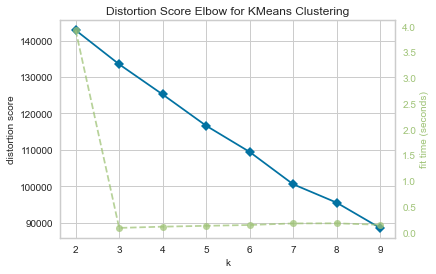

In [8]:
KClusterer = KMeans(random_state=9)
visualizer = KElbowVisualizer(KClusterer, 
                              k=(2,10)
                             ) 
visualizer.fit(df_scaled)      
visualizer.show()
plt.show()

**Written answer (2 pts):** the visualizer fails to find an optimal number of clusters using the elbow method

2. Try between 2 and 6 clusters, using a seed of 9, and draw the silouhette plot for the K-means analysis. Report the silhouette scores. Do NOT use the built-in function `SilhouetteVisualizer()`.

/Users/oren/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.1317


/Users/oren/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.1422


/Users/oren/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.1529


/Users/oren/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.1431


/Users/oren/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.1491


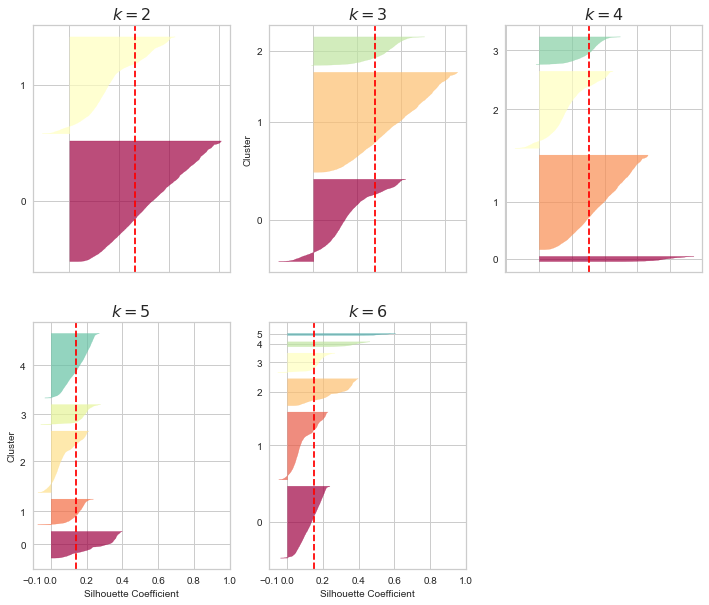

In [9]:
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl

plt.figure(figsize=(12, 10))

for k in range(2, 7):
    plt.subplot(2, 3, k - 1)
    
    kmeans = KMeans(n_clusters=k, random_state=9)
    y_pred = kmeans.fit_predict(df_scaled)
    silhouette_coefficients = silhouette_samples(df_scaled, y_pred)

    padding = len(df_scaled) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    silhouette_avg = silhouette_score(df_scaled, y_pred)
    print("For n_clusters =", k,
      "The average silhouette_score is :", silhouette_avg.round(4))

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()


**What is the optimal number of clusters using the silhouette method?**

**ANSWER HERE (2pts):**  the optimal number of clusters using this method is 4 as it has the highest average silhouette score, and there seems to be the least amount of of bad clustering, as there seems to be only a bit of the yellow cluster not clustered properly

3. Use the first and second principle components of the data as the x and y axis, draw the scatter plot where points are differentiated by clusters. Hints: you need to first perform dimension reduction with PCA using 2 components.

/Users/oren/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


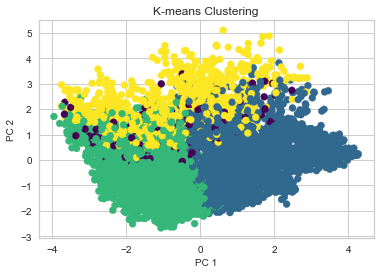

In [10]:
# perform PCA to reduce dimensionality
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
kmeans4 = KMeans(n_clusters=4, random_state=9)
cluster_labels = kmeans4.fit_predict(df_scaled)

# Assign cluster labels to each data point
plt.scatter(df_pca[:,0], df_pca[:,1], c=cluster_labels, cmap='viridis')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('K-means Clustering')
plt.show()


4. The objective of any cluster analysis over customer data is to create a reasonable segmentation of your customers. Using the number of clusters you have decided in Question 1, create a table (using `pandas.DataFrame.groupby`) of the averages per variable (`Age`, `Work_Experience`, `Family_Size`) of each cluster (use the original, non-scaled, variables). Write a conclusion on the characteristics of each cluster.

In [11]:
clusters = kmeans4.labels_
dataOHE['Cluster'] = clusters
dataOHE['Cluster'] = dataOHE['Cluster'].replace({0: 'A', 1: 'B', 2: 'C', 3: 'D'})
d = dataOHE.groupby('Cluster')[['Age', 'Work_Experience', 'Family_Size']].mean()
dataOHE.drop('Cluster', axis=1)
d

,Age,Work_Experience,Family_Size
Cluster,,,
A,38.630542,2.512315,3.221675
B,54.010712,2.095072,2.653455
C,32.471245,3.036477,2.853105
D,38.936581,2.186581,3.493566


**ANSWER HERE (2pts):** 

Cluster A: this is a middle aged group with a good amount of work experience and a large family. This is probably a group of people that are more work reliant to support a family.


Cluster D: this is also a middle aged group except in comparison to cluster A, it has little work experience but the largest family of all the groups. This is a group of people that are more family focused and do not need to rely on work experience.


Cluster B: this is the oldest age group by far, which characterizes them from the other clusters, they have the smallest family and the smallest work experience, indicating that they are retired and have no dependencies (children) young enough to be a customer


Cluster D: this is the youngest age group which sets them apart, as well as their largest amount of work experience (and mediocre family size), which sets them apart as they are most likely younger people coming out of universities with jobs.

## Question 3: Second Strategy (45 pts) 

1. First performing dimension reduction with PCA using 4 components. Look for the best number of clusters (between 3 to 6) using `Agglomerative clustering` with `affinity = 'cosine'` and `linkage = 'average'` and Silhuoette analysis.

In [12]:
pca = PCA(n_components=4)
df_pca = pca.fit_transform(df_scaled)
for k in range(3, 7):
    Agglom = AgglomerativeClustering(n_clusters=k,    
                                    affinity='cosine', 
                                    linkage="average")
    cluster_labels = Agglom.fit_predict(df_pca)
    silhouette_avg = silhouette_score(df_pca, cluster_labels)
    print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg.round(4))

/Users/oren/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.2618


/Users/oren/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.2784


/Users/oren/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.2235


/Users/oren/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.2071


**Written Answer:** How many clusters is select based on the previous results?

**ANSWER HERE (2pts):** Based on these results, we should select 4 clusters as it has the highest average silhouette score of 0.2709

2. Graph the scatter plot of the PCA-transformed data differentiated by cluster. Use the first and second principal components of the data as the x and y axis.


/Users/oren/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


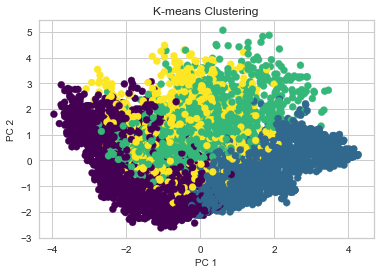

In [13]:
#use 4 as it is the best from earlier
Agglom4 = AgglomerativeClustering(n_clusters=4,    
                                    affinity='cosine', 
                                    linkage="average")
cluster_labels = Agglom4.fit_predict(df_pca)

plt.scatter(df_pca[:,0], df_pca[:,1], c=cluster_labels, cmap='viridis')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('K-means Clustering')
plt.show()

3. Make the boxplot `Age` vs `Family_Size` based on the dataFrame before standardization, and use `hue = "Your_Cluster_Label"` in the plot function to show the differences among clusters.

<Axes: xlabel='Family_Size', ylabel='Age'>

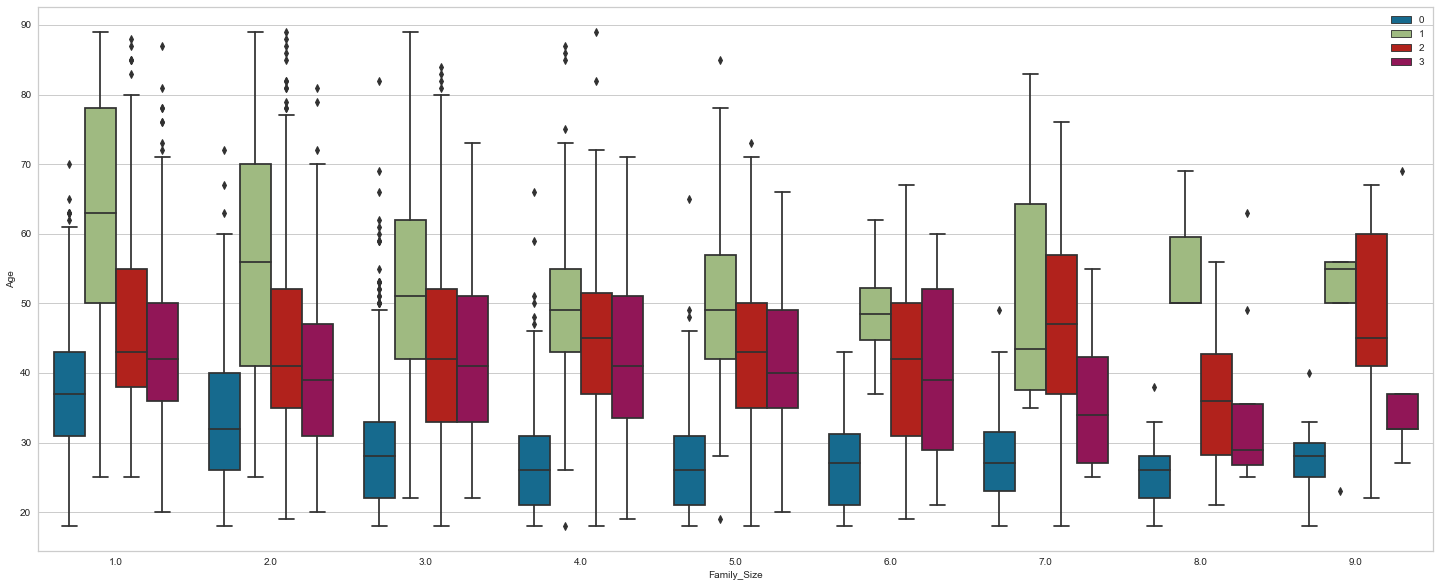

In [14]:
plt.figure(figsize=(25, 10))
sns.boxplot(x = dataOHE.Family_Size, y = dataOHE.Age, hue = cluster_labels)

Yes, you need to provide one boxplot with Age as y-axis, Family_Size as x-axis and hue='Your_Cluster_Label, so that clusters are differentiated by colors.



4. Using the number of clusters you have decided in Question 2 and `pandas.DataFrame.groupby`, create a table of the averages per variable (`Age`, `Work_Experience`, `Family_Size`) of each cluster (use the original, non-scaled, variables). Write a conclusion on the characteristics of each cluster.

In [15]:
clusters = Agglom4.labels_
dataOHE['Cluster'] = clusters
dataOHE['Cluster'] = dataOHE['Cluster'].replace({0: 'A', 1: 'B', 2: 'C', 3: 'D'})
d = dataOHE.groupby('Cluster')[['Age', 'Work_Experience', 'Family_Size']].mean()
dataOHE.drop('Cluster', axis=1)
d

,Age,Work_Experience,Family_Size
Cluster,,,
A,30.696441,2.932740,3.132028
B,55.474798,2.133737,2.560148
C,44.423358,2.197810,2.972993
D,42.194079,2.576754,2.798246


**ANSWER HERE (2pts):** 

Cluster A: this cluster is categorized by all its variables, as it has the lowest average age by far, despite having the largest family size and work experience, as they are most likely younger people with work experience from jobs right out of university, and either have kids or are financially attached to their parents

Cluster B: this cluster is categorized by their age, as they are significantly older than the rest, and have the littlest work experience and littlest family size, as they are all old people out of work with no young financial dependencies. 

Cluster C and B: These clusters are the most similar, except C is older has less work experience and less family size. Thus, group D is likey working more with more young kids as financial dependencies